In [5]:
import argparse
import logging
import os
import torch
from torch.utils.data import DataLoader, random_split
import json
import rdkit.Chem as Chem
import rdkit
from rxntorch.containers.reaction import Rxn
from rxntorch.containers.molecule import Mol
from rxntorch.containers.dataset import RxnGraphDataset as RxnGD
from rxntorch.utils import collate_fn
from rxntorch.models.yield_network import YieldNet as RxnNet, YieldTrainer as RxnTrainer
from rxntorch.models import yield_network
import warnings
warnings.filterwarnings("ignore")
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import numpy as np
from sklearn.metrics import roc_auc_score,r2_score

from IPython.display import SVG

In [6]:
parser = argparse.ArgumentParser()

parser.add_argument("-p", "--dataset_path", type=str, default='./data/', help="train dataset")
parser.add_argument("-mp","--mol_path", type=str, default='doyle_reaction_mols', help="path to mol files")

parser.add_argument("-c", "--train_dataset", required=True, type=str, help="train dataset")
parser.add_argument("-t", "--test_dataset", type=str, default=None, help="test set")
parser.add_argument("-op", "--output_path", type=str, default='./output/', help="saved model path")
parser.add_argument("-o", "--output_name", required=True, type=str, help="e.g. rxntorch.model")
parser.add_argument("-ds", "--train_split", type=float, default=0.7, help="Ratio of samples to reserve for test data")
parser.add_argument("-vs", "--valid_split", type=float, default=0.333, help="Ratio of samples to reserve for valid data")
parser.add_argument("-dr", "--dropout_rate", type=float, default=0.333, help="Ratio of samples to reserve for valid data")

parser.add_argument("-b", "--batch_size", type=int, default=1, help="number of batch_size")
parser.add_argument("-tb", "--test_batch_size", type=int, default=None, help="batch size for evaluation")
parser.add_argument("-e", "--epochs", type=int, default=10, help="number of epochs")
parser.add_argument("-hs", "--hidden", type=int, default=200, help="hidden size of model layers")
parser.add_argument("-l", "--layers", type=int, default=3, help="number of layers")

parser.add_argument("--lr", type=float, default=1e-2, help="learning rate of the optimizer")
parser.add_argument("-lrd", "--lr_decay", type=float, default=0.9,
                    help="Decay factor for reducing the learning rate")
parser.add_argument("-lrs", "--lr_steps", type=int, default=10000,
                    help="Number of steps between learning rate decay")
parser.add_argument("-awd","--adam_weight_decay", type=float, default=0.0, help="weight_decay of adam")
parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam second beta value")
parser.add_argument("-gc", "--grad_clip", type=float, default=None, help="value for gradient clipping")
parser.add_argument("-pw", "--pos_weight", type=float, default=None, help="Weights positive samples for imbalance")

parser.add_argument("-w", "--num_workers", type=int, default=4, help="dataloader worker size")
parser.add_argument("--with_cuda", type=bool, default=True, help="training with CUDA: true, or false")
parser.add_argument("--cuda_devices", type=int, nargs='*', default=None, help="CUDA device ids")

parser.add_argument("--log_freq", type=int, default=50, help="printing loss every n iter: setting n")
parser.add_argument("--seed", type=int, default=12, help="random seed")
parser.add_argument("-ud","--use_domain", type=str, required='True', help="use domain features or not")

_StoreAction(option_strings=['-ud', '--use_domain'], dest='use_domain', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='use domain features or not', metavar=None)

In [7]:
#args = parser.parse_args()
data_type='dy'
args = parser.parse_args(args=['-p','data/','-c', data_type+'_reactions_data.json', '-o', 'model.01','-ud', 'False', '-mp', data_type+'_reaction_mols'])
random_seed=args.seed
dataset = RxnGD(data_type+'/'+data_type+'_reactions_data.json',path=args.dataset_path)
sample = dataset[3]
sample['atom_feats'].shape, sample['bond_feats'].shape, sample['atom_graph'].shape,sample['bond_graph'].shape,sample['domain_feats'].shape,sample["binary_feats"].shape

(torch.Size([87, 20]),
 torch.Size([89, 5]),
 torch.Size([87, 15]),
 torch.Size([87, 15]),
 torch.Size([1, 224]),
 torch.Size([15, 15, 15]))

In [8]:
afeats_size, bfeats_size, binary_size, dmfeats_size = (sample["atom_feats"].shape[-1], sample["bond_feats"].shape[-1],
                                        sample["binary_feats"].shape[-1], sample['domain_feats'].shape[-1])
d1,d2,d3 = sample["binary_feats"].shape
binary_size= d3*d2

test_batch_size = args.test_batch_size if args.test_batch_size is not None else args.batch_size
dataloader = DataLoader(dataset, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)

torch.manual_seed(random_seed)
net = RxnNet(depth=args.layers, dropout=args.dropout_rate, afeats_size=afeats_size, bfeats_size=bfeats_size,
             hidden_size=args.hidden, binary_size=binary_size,dmfeats_size=dmfeats_size, use_domain=args.use_domain)
trainer = RxnTrainer(net, lr=args.lr, betas=(args.adam_beta1, args.adam_beta2), weight_decay=args.adam_weight_decay,
                     with_cuda=args.with_cuda, cuda_devices=args.cuda_devices, log_freq=args.log_freq,
                     grad_clip=args.grad_clip, pos_weight=args.pos_weight, lr_decay=args.lr_decay,
                     lr_steps=args.lr_steps)

In [9]:
args = parser.parse_args(args=['-p','data/','-c', data_type+'_reactions_data.json', '-o', 'model.01','-ud', 'False', '-mp', data_type+'_reaction_mols'])
random_seed=args.seed



In [10]:

def get_smiles_from_raw_json(json):
    reactant_smiles= '.'.join([reactant['smiles'] for reactant in json['reactants']])
    if 'solvent' in json.keys():
        solvent_smiles = json['solvent'][0]
    else:
        solvent_smiles = 'CS(=O)C'
    
    base_smiles= json['base']['smiles']
    rxn_smiles= reactant_smiles+'.'+ solvent_smiles+'.'+base_smiles
    return rxn_smiles

def get_component_idx(mol):
    comp = {}
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    all_atoms=set(symbols)
    n_atoms=len(all_atoms)
    cumulative_idx=0
    for i, s in enumerate(smiles.split('.')):
        mol = Chem.MolFromSmiles(s)
        for atom in mol.GetAtoms():
            comp[cumulative_idx-1] = i #this approach in getting cumulative indx works and it aligns 
                                        # with vieweing all mols in one mol and then getting the atom idxs
            cumulative_idx +=1      # bases don't have bonds!!!
    return comp

def get_bond_map(mol):
    bond_map=defaultdict()
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bond_map[(a1,a2)] = bond.GetIdx()
        bond_map[(a2,a1)] = bond.GetIdx()
        #print(a1,a2,"bond: ",bond.GetIdx())
    return bond_map

def get_top_activated(gnn_weights, threshold,bond_map):
    most_activated_atoms=set()
    most_activated_bonds=set()
    for i in range(gnn_weights.shape[0]):
        for j in range(gnn_weights.shape[1]):
            if abs(gnn_weights[i][j])>threshold:
                most_activated_atoms.add(i)
                most_activated_atoms.add(j)
                #if (i,j) in bond_map:
                #most_activated_bonds.add(bond_map[(i,j)])
                    
    return most_activated_atoms, most_activated_bonds

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import DrawingOptions
 

DrawingOptions.atomLabelFontSize = 55
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3.0
def moltosvg(mol,highlightAtoms,output,molSize=(600,600),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,highlightAtoms)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    d2d = Draw.MolDraw2DCairo(molSize[0],molSize[1])
    d2d.DrawMolecule(mc,highlightAtoms)
    d2d.FinishDrawing()
    png_data = d2d.GetDrawingText()

    # save png to file
    with open(output, 'wb') as png_file:
        png_file.write(png_data)
    return svg.replace('svg:','')

In [11]:
PATH='output//yield.model'
model_name='dy_models/dy_model_5.0.1-no_domain-11-200-1-100-0.01-0.9-10000-40'
model_name= 'su_model_5.2.0-rdkt-no-abs-w_domain-20-200-2-200-0.01-0.5-10000-40'
model_name = 'dy_model_4.6.3-noabs-w_domain-11-200-2-200-0.01-0.5-10000-40'
model_name= 'dy_model_4.6.3-noabs-w_domain-15-200-2-200-0.01-0.5-10000-40'


PATH='output/'+model_name+'/yield.model'
betas=(args.adam_beta1,args.adam_beta2)
device = torch.device('cpu')
model = torch.load(PATH, map_location=device)
optimizer = opt.Adam(model.parameters(), lr=args.lr, betas=betas, weight_decay=0)

with open('data/'+data_type+'/'+data_type+'_reactions_data.json') as datafile:
    raw_data = json.load(datafile)

In [10]:
for name, child in model.named_children():
    print('name: ', name)
    print('isinstance({}, nn.Module): '.format(name), isinstance(child, nn.Module))
    print('=====')


name:  wln
isinstance(wln, nn.Module):  True
=====
name:  attention
isinstance(attention, nn.Module):  True
=====
name:  yield_scoring
isinstance(yield_scoring, nn.Module):  True
=====
name:  dropout
isinstance(dropout, nn.Module):  True
=====


In [11]:
for name , param in model.named_parameters(): 
    print('type(param): ', type(param))
    print('isinstance(param, nn.Module): ', isinstance(param, nn.Module))
    print('isinstance(param, nn.Parameter): ', isinstance(param, nn.Parameter))
    print('isinstance(param, torch.Tensor) ', isinstance(param, torch.Tensor))
    print("requires grad: " , name, ':', param.requires_grad)
    print('=====')
    

type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.fc1.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_nei.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_nei.bias : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_atom.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  

In [12]:
model.wln

WLNet(
  (fc1): Linear(in_features=29, out_features=200, bias=False)
  (graph_conv_nei): Linear(in_features=206, out_features=200, bias=True)
  (graph_conv_atom): Linear(in_features=400, out_features=200, bias=True)
  (fc2atom_nei): Linear(in_features=200, out_features=200, bias=False)
  (fc2bond_nei): Linear(in_features=6, out_features=200, bias=False)
  (fc2): Linear(in_features=200, out_features=200, bias=False)
  (dropout): Dropout(p=0.04, inplace=False)
)

In [125]:
for name , param in model.named_parameters(): 
    print(name,param.shape)

wln.fc1.weight torch.Size([200, 29])
wln.graph_conv_nei.weight torch.Size([200, 206])
wln.graph_conv_nei.bias torch.Size([200])
wln.graph_conv_atom.weight torch.Size([200, 400])
wln.graph_conv_atom.bias torch.Size([200])
wln.fc2atom_nei.weight torch.Size([200, 200])
wln.fc2bond_nei.weight torch.Size([200, 6])
wln.fc2.weight torch.Size([200, 200])
attention.fcapair.weight torch.Size([200, 200])
attention.fcbinary.weight torch.Size([200, 15])
attention.fcbinary.bias torch.Size([200])
attention.fcattention.weight torch.Size([1, 200])
attention.fcattention.bias torch.Size([1])
yield_scoring.fclocal.weight torch.Size([200, 200])
yield_scoring.fcglobal.weight torch.Size([200, 200])
yield_scoring.fcglobal.bias torch.Size([200])
yield_scoring.fcbinary.weight torch.Size([200, 225])
yield_scoring.fcscore.weight torch.Size([1, 200])
yield_scoring.fcscore.bias torch.Size([1])
yield_scoring.dcscore.weight torch.Size([1, 200])
yield_scoring.dcscore.bias torch.Size([1])
yield_scoring.domain.weight to

In [13]:
i=0
for layer in model.modules():
    i+=1
    print(i,layer)

1 YieldNet(
  (wln): WLNet(
    (fc1): Linear(in_features=29, out_features=200, bias=False)
    (graph_conv_nei): Linear(in_features=206, out_features=200, bias=True)
    (graph_conv_atom): Linear(in_features=400, out_features=200, bias=True)
    (fc2atom_nei): Linear(in_features=200, out_features=200, bias=False)
    (fc2bond_nei): Linear(in_features=6, out_features=200, bias=False)
    (fc2): Linear(in_features=200, out_features=200, bias=False)
    (dropout): Dropout(p=0.04, inplace=False)
  )
  (attention): Attention(
    (fcapair): Linear(in_features=200, out_features=200, bias=False)
    (fcbinary): Linear(in_features=15, out_features=200, bias=True)
    (fcattention): Linear(in_features=200, out_features=1, bias=True)
  )
  (yield_scoring): YieldScoring(
    (fclocal): Linear(in_features=200, out_features=200, bias=False)
    (fcglobal): Linear(in_features=200, out_features=200, bias=True)
    (fcbinary): Linear(in_features=225, out_features=200, bias=False)
    (fcscore): Linea

In [135]:
dataset[sample_num]['yield_label']
print(high_yield_ids)

[6, 8, 19, 52, 61, 63, 74, 83, 85, 96, 138, 140, 146, 148, 149, 151, 162, 309, 310, 313, 314, 316, 319, 320, 321, 322, 324, 332, 335, 346, 354, 357, 363, 364, 365, 366, 368, 369, 374, 375, 376, 377, 379, 380, 385, 386, 387, 390, 396, 397, 398, 401, 434, 440, 441, 442, 445, 451, 452, 453, 454, 456, 467, 474, 485, 489, 507, 511, 517, 518, 539, 540, 542, 543, 544, 545, 547, 551, 552, 553, 554, 555, 556, 558, 565, 566, 572, 573, 575, 576, 577, 578, 580, 583, 584, 586, 587, 588, 589, 591, 594, 595, 597, 598, 599, 600, 602, 606, 609, 610, 617, 618, 619, 621, 622, 623, 624, 628, 629, 630, 632, 639, 640, 643, 650, 651, 654, 661, 662, 663, 665, 666, 668, 669, 672, 673, 674, 675, 676, 677, 678, 679, 683, 684, 685, 687, 688, 690, 691, 694, 696, 699, 701, 705, 707, 710, 712, 718, 738, 745, 749, 754, 756, 760, 765, 767, 782, 784, 790, 793, 795, 797, 800, 801, 804, 815, 826, 848, 850, 853, 855, 856, 859, 861, 864, 870, 872, 874, 881, 883, 886, 888, 889, 892, 894, 897, 899, 900, 903, 905, 908, 910, 9

In [12]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

def plot_activations(gnn_weights,sample_num,actual,predicted,good_bad):
    
    threshold= round(np.quantile(np.abs(gnn_weights),0.99),2)
    most_activated_atoms, most_activated_bonds = get_top_activated(gnn_weights, threshold,bond_map)
    fig_path='vis/'+model_name+'/'+good_bad+'/'
    image_path=fig_path+str(sample_num)+'_Y_'+str(actual)+'_Pred_'+str(predicted)+'_'+str(threshold)+'.png'
    if not os.path.exists(fig_path):
        os.mkdir(fig_path)
    SVG(moltosvg(mol,most_activated_atoms,image_path,molSize=(600,600)))

In [23]:
#sample_num=870
bad_preds=[]
#for sample_num in samples:#len(raw_data))
for sample_num in range(,len(raw_data)):


    curr_sample_raw = raw_data[sample_num]
    smiles= get_smiles_from_raw_json(curr_sample_raw)
    mol = Chem.MolFromSmiles(smiles)
    bond_map = get_bond_map(mol)
    yield_label = dataset[sample_num]['yield_label']
    

    ############### Define hook
    save_output = SaveOutput()
    hook_handles = [];i=0
    for layer in model.modules():
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
        i+=1

        
    ############### Do one pass of the model
    model.eval()
    if yield_label>0.8 or yield_label<0.2:
        for i, data in enumerate(dataloader):
            if i<=sample_num:
                if i==sample_num:
                    mask_neis = torch.unsqueeze(data['n_bonds'].unsqueeze(-1) > torch.arange(0, 15, dtype=torch.int32).view(1, 1, -1), -1)
                    max_n_atoms = data['n_atoms'].max()
                    mask_atoms = torch.unsqueeze(data['n_atoms'].unsqueeze(-1) > torch.arange(0, max_n_atoms, dtype=torch.int32).view(1, -1),-1)
                    with torch.no_grad():
                        model.eval()
                        yield_scores = model.forward(data['atom_feats'], data['bond_feats'],data['atom_graph'], data['bond_graph'], 
                        data['n_bonds'],data['n_atoms'], data['binary_feats'], mask_neis, mask_atoms,data['sparse_idx'],data['domain_feats'])
            else:
                break

        predicted = round(yield_scores.item(),2)
        actual = round(yield_label.item(),2)
        gnn_weights= save_output.outputs[11].detach().to('cpu').squeeze(0).squeeze(2).numpy()
        ############### plot the figures
        if actual>0.8:

            if abs(predicted-actual)>0.25:
                print(sample_num,f"yield label raw: {round(raw_data[sample_num]['yield']/100,2)}")
                print(f"predicted yield: {predicted }, yield label: {actual }")
                good_bad= 'bad'
                plot_activations(gnn_weights,sample_num,actual,predicted,good_bad)
                bad_preds.append(sample_num)
                
            #if False:
            elif abs(predicted-actual)<0.1:
                print(sample_num,f"yield label raw: {round(raw_data[sample_num]['yield']/100,2)}")
                print(f"predicted yield: {predicted }, yield label: {actual }")
                good_bad= 'good'
                plot_activations(gnn_weights,sample_num,actual,predicted,good_bad)

        elif actual <0.5:
            
            if abs(predicted-actual)>0.25:
                print(sample_num,f"yield label raw: {round(raw_data[sample_num]['yield']/100,2)}")
                print(f"predicted yield: {predicted }, yield label: {actual }")
                good_bad= 'bad'
                plot_activations(gnn_weights,sample_num,actual,predicted,good_bad)
                bad_preds.append(sample_num)
                
            #if False:
            elif abs(predicted-actual)<0.1:
                print(sample_num,f"yield label raw: {round(raw_data[sample_num]['yield']/100,2)}")
                print(f"predicted yield: {predicted }, yield label: {actual }")
                good_bad= 'good'
                plot_activations(gnn_weights,sample_num,actual,predicted,good_bad)

    

888 yield label raw: 0.01
predicted yield: -0.04, yield label: 0.01
889 yield label raw: 0.13
predicted yield: 0.08, yield label: 0.13
891 yield label raw: 0.05
predicted yield: 0.08, yield label: 0.05
894 yield label raw: 0.82
predicted yield: 1.07, yield label: 0.82
895 yield label raw: 0.9
predicted yield: 0.99, yield label: 0.9
896 yield label raw: 0.94
predicted yield: 0.93, yield label: 0.94
900 yield label raw: 0.09
predicted yield: 0.12, yield label: 0.09
901 yield label raw: 0.13
predicted yield: 0.12, yield label: 0.13
902 yield label raw: 0.13
predicted yield: 0.15, yield label: 0.13
903 yield label raw: 0.01
predicted yield: -0.03, yield label: 0.01
904 yield label raw: 0.11
predicted yield: 0.12, yield label: 0.11
905 yield label raw: 0.11
predicted yield: 0.11, yield label: 0.11
906 yield label raw: 0.04
predicted yield: 0.03, yield label: 0.04
915 yield label raw: 0.03
predicted yield: 0.07, yield label: 0.03
927 yield label raw: 0.05
predicted yield: 0.12, yield label: 

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [24]:
sample_num

974

In [14]:
raw_data[sample_num]['yield']

'#VALUE!'

In [11]:
actual

-1

In [12]:
sample_num

741

In [16]:
round(yield_scores.item(),2)

0.12

4.04


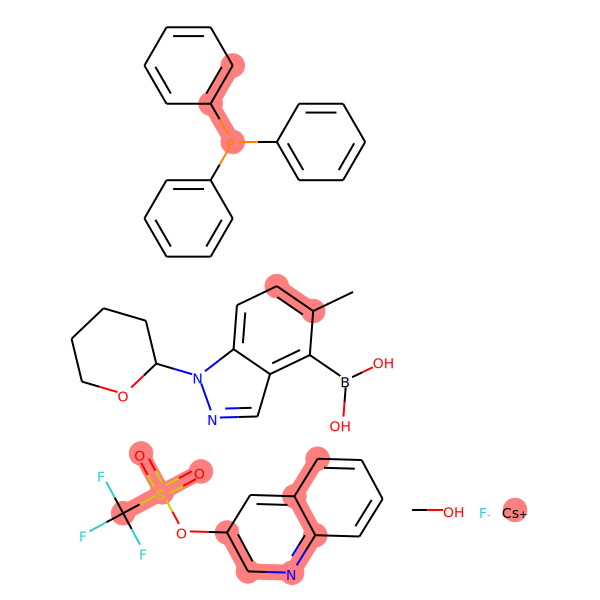

In [71]:
res=[]

for i in range(len(save_output.outputs)):
    np.save('data/image_'+str(i)+'.npy', save_output.outputs[i].detach().to('cpu').numpy())
    #res.append(save_output.outputs[i].detach().to('cpu').numpy())
#image= save_output.outputs.detach().to('cpu').numpy()    


In [13]:
def iterate(model,optimizer,epoch, data_loader, train=True,valid=False):
    avg_loss, tmp_r2 =0.0, 0
    iters = len(data_loader)
    n_samples = len(data_loader.dataset)
    correct_yields , pred_yields =np.array([[0]]), np.array([[0]])
    model.eval()
    if True:
        for i, data in enumerate(data_loader):
            mask_neis = torch.unsqueeze(data['n_bonds'].unsqueeze(-1) > torch.arange(0, 15, dtype=torch.int32).view(1, 1, -1), -1)
            max_n_atoms = data['n_atoms'].max()
            mask_atoms = torch.unsqueeze(data['n_atoms'].unsqueeze(-1) > torch.arange(0, max_n_atoms, dtype=torch.int32).view(1, -1),-1)
            with torch.no_grad():
                model.eval()
                yield_scores = model.forward(data['atom_feats'], data['bond_feats'],data['atom_graph'], 
                                                    data['bond_graph'], data['n_bonds'],data['n_atoms'], data['binary_feats'], 
                                                    mask_neis, mask_atoms,data['sparse_idx'],data['domain_feats'])
                criteria=nn.MSELoss()
                loss= criteria(yield_scores, data['yield_label'])
                loss = torch.mean(loss)
                avg_loss += loss.item()
                aa=data['yield_label'].cpu().detach().numpy()
                bb=yield_scores.cpu().detach().numpy()
                correct_yields=np.append(correct_yields,aa)
                pred_yields=np.append(pred_yields,bb)

        tmp_r2=r2_score(correct_yields,pred_yields)
        logging.info("Epoch: {:2d}  Loss: {:f}  R2: {:6.2%} ".format(epoch,avg_loss, tmp_r2))
        return correct_yields,pred_yields,tmp_r2,avg_loss


In [14]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, dy_dataloader, train=False,valid=False)

02/02/21 11:35:08: Epoch:  1  Loss: 28.884723  R2: 91.86% 


In [18]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, az_dataloader, train=False,valid=False)

02/02/21 11:40:26: Epoch:  1  Loss: 133.645681  R2: -103.15% 


In [21]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, su_dataloader, train=False,valid=False)

02/02/21 11:42:58: Epoch:  1  Loss: 872.601692  R2: -128.78% 


In [22]:
np.mean(pred_yields),np.std(pred_yields)

(0.11045819235104222, 0.07012773506296444)

In [23]:
np.mean(correct_yields),np.std(correct_yields)

(0.4178988746543945, 0.2872947228123882)

In [24]:
print(sorted([round(i,2) for i in list(pred_yields)]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

In [18]:
with open('data/'+args.output_name+'_y_true.txt', 'w') as f_true, open('data/'+args.output_name+'_y_pred.txt', 'w') as f_pred:
    f_true.write(','.join(map(str, [float(n[0]) for n in a2])))
    f_pred.write(','.join(map(str, [float(n[0]) for n in b2])))
    
    
with open('data/'+args.output_name+'_train_scores.txt', 'w') as train_r2, open('data/'+args.output_name+'_test_scores.txt', 'w') as test_r2:
    train_r2.write(','.join(map(str, [float(n) for n in train_scores])))
    test_r2.write(','.join(map(str, [float(n) for n in test_scores])))

In [ ]:
roc_auc_score( data['yield_label'].cpu(), yield_scores.cpu().detach().numpy() )

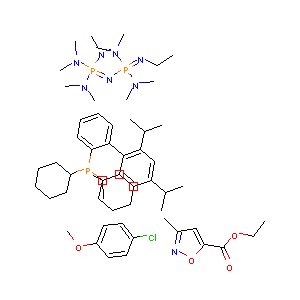

In [13]:
from rdkit.Chaem import Draw
Draw.MolToImage(mol)
#Chem.FindMolChiralCenters(mol,force=True)

In [11]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
AllChem.Compute2DCoords(m)
for atom in m.GetAtoms():
    print(atom.GetSymbol(),atom.GetIdx())



C 0
C 1
C 2
C 3
C 4
C 5
C 6
C 7
Br 8


In [14]:
import re
import glob


def get_atom_mapping_doyle(mol_dir):
    
    smiles_mapping=defaultdict(dict) 
    
    for mol_fn in glob.glob(mol_dir):
        atoms , labels, atom_mapping =[], [], []
        if 'methyl-isoxazole-5-carboxylate' in mol_fn:
            print(mol_fn)
            m = Chem.MolFromMolFile(mol_fn)
            smiles=Chem.MolToSmiles(m)
            mol_lines=open(mol_fn,'r').readlines()

            for i,line in enumerate(mol_lines[4:]):
                l=re.sub(' +', ' ', line.strip('\n'))
                l2=l.split(' ')
                if len(l2)==17:
                    atom=l2[4]
                    if atom !='' and '*' not in atom and 'H' not in atom:
                        atoms.append(atom)
                if "atom_labels" in line:
                    labels=[i.strip('*') for i in mol_lines[i+1+4].strip('\n').split(' ') if ((i!='') and ('H' not in i))]
                    print(labels)
            if len(atoms)==len(labels):
                for i in range(len(atoms)):
                    atom_mapping.append((atoms[i],labels[i]))            
                print(atom_mapping)
            else:
                print('Atoms and lables don\'t match')
                atom_mapping=[]

            if smiles not in smiles_mapping:
                print(mol_fn.split('/')[-1].split('.')[0])
                smiles_mapping[mol_fn.split('/')[-1].split('.')[0]]=atom_mapping
            else:
                print("key exsists")
    return smiles_mapping



In [ ]:
ope

In [22]:
for mol_fn in glob.glob("data/doyle_reaction_mols/*.mol"):
    if 'methyl-isoxazole-5-carboxylate' in mol_fn:
        print("te")

te


In [15]:
smiles_mapping=get_atom_mapping_doyle("data/doyle_reaction_mols/*.mol")

data/doyle_reaction_mols/methyl-isoxazole-5-carboxylate.mol
['O1', 'N1', 'C3', 'C4', 'C5', 'C1', 'O1', 'O2', 'C2']
[('O', 'O1'), ('N', 'N1'), ('C', 'C3'), ('C', 'C4'), ('C', 'C5'), ('C', 'C1'), ('O', 'O1'), ('O', 'O2'), ('C', 'C2')]
methyl-isoxazole-5-carboxylate


In [16]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

[('O', 'O1'),
 ('N', 'N1'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C5'),
 ('C', 'C1'),
 ('O', 'O1'),
 ('O', 'O2'),
 ('C', 'C2')]

In [13]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

{}

In [30]:
smiles_mapping['1-bromo-4-ethylbenzene']

[('C', 'C1'),
 ('C', 'C4'),
 ('C', 'C2'),
 ('C', 'C2'),
 ('C', 'C3'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C1'),
 ('Br', 'Br1')]

In [148]:
atoms=[{"name": "C1", "atomic_num": 6, "partial_charge": -0.025, "nmr_shift": 132.85}, {"name": "C2", "atomic_num": 6, "partial_charge": -0.058, "nmr_shift": 125.36}, {"name": "C3", "atomic_num": 6, "partial_charge": -0.211, "nmr_shift": 122.91}, {"name": "C4", "atomic_num": 6, "partial_charge": 0.167, "nmr_shift": 136.02}, {"name": "H2", "atomic_num": 1, "partial_charge": 0.104, "nmr_shift": 7.11}, {"name": "H3", "atomic_num": 1, "partial_charge": 0.14, "nmr_shift": 6.97}]

In [161]:
p_charge_dict=defaultdict(float)
nmr_dict=defaultdict(float)
for atom in atoms:
    p_charge_dict[atom['name']]=atom['partial_charge']
    nmr_dict[atom['name']]=atom['nmr_shift']

In [162]:
p_charge_dict

defaultdict(float,
            {'C1': -0.025,
             'C2': -0.058,
             'C3': -0.211,
             'C4': 0.167,
             'H2': 0.104,
             'H3': 0.14})

In [166]:
m=Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
partial_charges=[]
nmr_shifts=[]

for atom in m.GetAtoms():
    atom_label=smiles_mapping['1-bromo-4-ethylbenzene'][atom.GetIdx()][1]
    partial_charges.append(p_charge_dict[atom_label])
    nmr_shifts.append(nmr_dict[atom_label])
    


In [165]:
partial_charges

[-0.025, 0.167, -0.058, -0.058, -0.211, -0.211, 0.167, -0.025, 0.0]

In [167]:
nmr_shifts

[132.85, 136.02, 125.36, 125.36, 122.91, 122.91, 136.02, 132.85, 0.0]

In [92]:
mm=Chem.MolFromSmiles('CCc1ccc(Br)cc1')

In [123]:
mm.GetAtoms()

In [126]:
for atom in mm.GetAtoms():
    print(atom.GetIdx(),atom.GetSymbol())

0 C
1 C
2 C
3 C
4 C
5 C
6 Br
7 C
8 C


In [ ]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
Chem.MolToSmiles(m)
#AllChem.Compute2DCoords(m2)
#for atom in m.GetAtoms():
    #print(atom.GetSymbol(),atom.GetIdx())
#print(Chem.MolToMolBlock(m))

In [177]:
import math
from sklearn.preprocessing import LabelEncoder
file_name = args.train_dataset
path = args.dataset_path
rxns = []
degree_codec = LabelEncoder()
symbol_codec = LabelEncoder()
expl_val_codec = LabelEncoder()
bond_type_codec = LabelEncoder()
max_nbonds = 10   
symbols = set()
degrees = set()
explicit_valences = set()
bond_types = set()

a=True
charges,shifts=[math.inf,-math.inf],[math.inf,-math.inf]
with open(os.path.join(path, file_name)) as datafile:
    data = json.load(datafile)
    for line in data:

        product=line['product']
        reactants=line['reactants']
        r_yield=line['yield']
     
        rxn = Rxn(product,reactants,r_yield)
        mol = Chem.MolFromSmiles(rxn.reactants_smile)
        #atom_idx = torch.tensor([atom.GetIdx()-1 for atom in mol.GetAtoms()], dtype=torch.int64)

        mol_reactants=rxn.reactants
        for mol_idx in range(1,len(mol_reactants)):
            current_molecule=mol_reactants[mol_idx]
            atoms=current_molecule.atoms
            #p_charge_dict=defaultdict(float)
            #nmr_dict=defaultdict(float)
            for atom in atoms:
                if 'partial_charge' in atom:
                    charges[0],charges[1]= min(charges[0],atom['partial_charge']), max(charges[1],atom['partial_charge'])
                if 'nmr_shift' in atom:
                    shifts[0],shifts[1]= min(shifts[0],atom['nmr_shift']), max(shifts[1],atom['nmr_shift'])

In [178]:
charges

[-0.96, 1.858]

In [179]:
shifts

[6.41, 168.89]